In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [3]:
os.chdir("/content/drive/MyDrive/MovieRSystem")

In [4]:
dataset = pd.read_csv("FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("CleanedData/ratings_test.csv")

## Content-Based Recommendation System - Pytorch

In [5]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### Make Dataset For Train

There are 671 users

In [7]:
len_users = ratings_train['userId'].unique().size
print(len_users)

671


2830 movies

In [8]:
len_dataset = len(dataset)
print(len_dataset)

2830


We need to save the id for later recommendation

In [9]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,14175,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,5703,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3771,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,6447,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4515,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1105,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1129,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,399,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,1982,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [10]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [11]:
indexToId[0]

949

In [12]:
dataset.drop(columns = ['id'], inplace = True)

Standardlize the dataset by each column to mean of 0 and standard deviation of 1

In [13]:
from sklearn import preprocessing

In [14]:
dataset = preprocessing.scale(dataset)

In [15]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor

In [16]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor

In [17]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [18]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [19]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

False

In [20]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [21]:
ratings_train

,userId,movieId,rating
0,0,1333,1.0
1,0,522,4.0
2,0,618,2.0
3,0,835,2.0
4,0,1614,2.5
...,...,...,...
31793,670,1454,5.0
31794,670,925,5.0
31795,670,1969,4.0
31796,670,1235,3.5


In [22]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

In [23]:
ratings_tensor[0][474]

tensor(0., dtype=torch.float64)

All works normally!

Now we will put all those codes into one block

In [24]:
"""
This codes convert dataset to Tensor data structure
"""

movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [25]:
from torch.autograd import Variable

In [26]:
ratings_train_tensor[0][474]

tensor(0., dtype=torch.float64)

### Train

We proposed a Regression Model for predicting Ratings

To predict the rate from user model $U$ and movies profiles $M$:

$U$ * $M^\top$ = $\hat{R}$ 

$L = MSE(\hat{R}, R)$ for all movies that have rated 

Find the partial derivatives for matrix $U$ : $ \dfrac{\partial L}{\partial U} $

Update $U$ based on $ \dfrac{\partial L}{\partial U} $

To calculate derivatives, we use **Autograd** of ***Pytorch***

In [27]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = ratings_pred.masked_select(mask)
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

'\nAutograd example\n'

In [28]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use MSELoss (**Mean Square Error**)

We also use this loss as metrics

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [30]:
from tqdm.notebook import tqdm

In [31]:
bestU = None
bestb = None
minLoss = 10e10

First try 3001 loop without regulization, lr = 0.005

In [32]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 57.94051990855853. Valid Loss: 59.53860396708518.
Epoch: 10. Train Loss: 51.30989605151483. Valid Loss: 54.49041156684292.
Epoch: 20. Train Loss: 45.62669889126641. Valid Loss: 50.232474243308104.
Epoch: 30. Train Loss: 40.80021164392678. Valid Loss: 46.670319478374516.
Epoch: 40. Train Loss: 36.704896415868696. Valid Loss: 43.68167700022045.
Epoch: 50. Train Loss: 33.21331884287731. Valid Loss: 41.151734138417545.
Epoch: 60. Train Loss: 30.21288587662614. Valid Loss: 38.98748178912827.
Epoch: 70. Train Loss: 27.611850015329335. Valid Loss: 37.11581993192499.
Epoch: 80. Train Loss: 25.33791841228405. Valid Loss: 35.481261648057945.
Epoch: 90. Train Loss: 23.33477468444814. Valid Loss: 34.04058814246482.
Epoch: 100. Train Loss: 21.558411015694798. Valid Loss: 32.76043549457833.
Epoch: 110. Train Loss: 19.974070277660584. Valid Loss: 31.615210146989842.
Epoch: 120. Train Loss: 18.553929603633815. Valid Loss: 30.585027933662957.
Epoch: 130. Train Loss: 17.27540050753

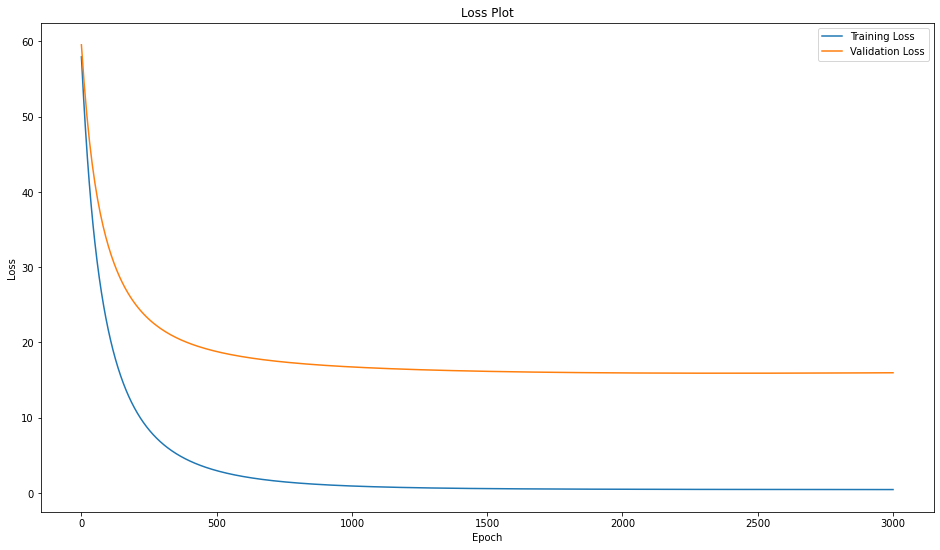

In [33]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization weight_decay on U = 0.05 and lr = 0.005

In [34]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.05)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [36]:
bestU = None
bestb = None
minLoss = 10e10

In [37]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 60.189948357891815. Valid Loss: 58.92834735937518.
Epoch: 10. Train Loss: 55.14644388819727. Valid Loss: 54.265277951015726.
Epoch: 20. Train Loss: 50.609353188956405. Valid Loss: 50.06896302910299.
Epoch: 30. Train Loss: 46.57234570343397. Valid Loss: 46.32340350127427.
Epoch: 40. Train Loss: 42.989120889071486. Valid Loss: 42.98440455297229.
Epoch: 50. Train Loss: 39.80462169077263. Valid Loss: 40.000671509985395.
Epoch: 60. Train Loss: 36.961914261622965. Valid Loss: 37.32041028735446.
Epoch: 70. Train Loss: 34.40944722565189. Valid Loss: 34.89623070829582.
Epoch: 80. Train Loss: 32.10588744789834. Valid Loss: 32.694225362446666.
Epoch: 90. Train Loss: 30.01804528033529. Valid Loss: 30.685999630637692.
Epoch: 100. Train Loss: 28.118328877644018. Valid Loss: 28.847599795063168.
Epoch: 110. Train Loss: 26.383612056624948. Valid Loss: 27.15891564491933.
Epoch: 120. Train Loss: 24.794553664249378. Valid Loss: 25.60327882920089.
Epoch: 130. Train Loss: 23.3349404504

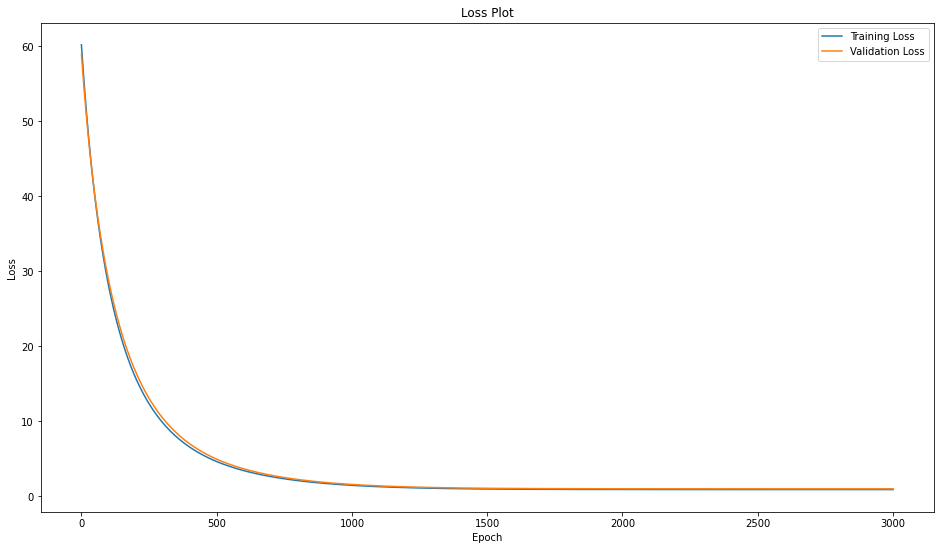

In [38]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

Take minLoss and bestU, bestb

In [39]:
minLoss

tensor(0.9489, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [40]:
bestU

tensor([[ 4.0285e-04, -2.5438e-03,  3.6949e-03,  ..., -1.9762e-12,
         -5.8832e-13, -5.0266e-13],
        [ 3.5373e-03, -1.0132e-02,  1.0812e-02,  ..., -3.1742e-03,
          4.0791e-03, -7.9047e-10],
        [ 6.3041e-03, -3.7687e-03,  1.3198e-03,  ...,  5.4221e-03,
         -3.6970e-03, -2.9928e-06],
        ...,
        [ 3.1861e-03, -2.8215e-04,  1.8962e-03,  ...,  2.8374e-03,
         -9.9142e-08, -9.6435e-08],
        [ 4.2721e-03, -6.8486e-03,  4.3069e-03,  ...,  6.1254e-03,
          9.4713e-16,  7.1340e-16],
        [-3.8510e-03, -1.5260e-03, -3.1519e-03,  ...,  3.3629e-03,
         -5.4986e-03,  3.1608e-03]], dtype=torch.float64, requires_grad=True)

In [41]:
bestU.detach().numpy().tofile("ModelStorage/U.txt")
bestb.detach().numpy().tofile("ModelStorage/b.txt")

In [42]:
with open("ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))